In [15]:
import pandas as pd
import numpy as np
from astropy.io import fits
from astropy.table import Table
from glob import glob
import matplotlib.pyplot as plt
import scipy
from math import lgamma
import seaborn as sns
%matplotlib inline

path = '/Users/chris/Desktop/mastrangelo/'

In [2]:
import matplotlib.pylab as pylab
pylab_params = {'legend.fontsize': 'large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(pylab_params)

total_stars = 67380

In [3]:
from ast import literal_eval

#https://stackoverflow.com/questions/52232742/how-to-use-ast-literal-eval-in-a-pandas-dataframe-and-handle-exceptions
def literal_eval_w_exceptions(x):
    try:
        return literal_eval(str(x))   
    except Exception as e:
        #print(e)
        pass

Read in and process data (pad and create zero bins)

In [4]:
truth = pd.read_csv(path+'collect_ground_truth.csv', converters=dict(transit_multiplicities=literal_eval))
recovery = pd.read_csv(path+'collect_recovery.csv', converters=dict(transit_multiplicities=literal_eval))


In [5]:
zero_bins = []
transit_multiplicity_zero_bin = []
for j, i in enumerate(truth.transit_multiplicities[:]):
    zero_bins.append(total_stars-np.sum(i))
    temp = truth.reset_index().transit_multiplicities[:][j]
    temp.insert(0,total_stars - np.sum(i))
    transit_multiplicity_zero_bin.append(temp)
truth['transit_multiplicity_zero_bin'] = transit_multiplicity_zero_bin

zero_bins = []
transit_multiplicity_zero_bin = []
for j, i in enumerate(recovery.transit_multiplicities[:]):
    zero_bins.append(total_stars-np.sum(i))
    temp = recovery.reset_index().transit_multiplicities[:][j]
    temp.insert(0,total_stars - np.sum(i))
    transit_multiplicity_zero_bin.append(temp)
recovery['transit_multiplicity_zero_bin'] = transit_multiplicity_zero_bin

In [6]:
def pad(lam):
    lam += [0.] * (7 - len(lam)) # pad with zeros to match length of k
    return lam

truth['transit_multiplicities'] = truth.transit_multiplicities.apply(pad)
recovery['transit_multiplicities'] = recovery.transit_multiplicities.apply(pad)


Prepare machinery for injection-recovery experiments

In [13]:
def prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c):
    """
    Each model run will use an evenly spaced (m,b, cutoff) tuple on a discrete 11x11x11 3D grid
    We're doing log(time), so slope is sampled linearly (everything gets logged together later)
    If a cutoff results in a zero probability, don't bother 

    gi_m: grid index on m axis
    gi_b: grid index on b axis
    gi_c: grid index for cutoff time axis
    """
    #cube[0] = -1e-9*np.logspace(8,10,11)[gi_m] # convert from year to Gyr
    cube[0] = np.linspace(-2,0,3)[gi_m] 
    cube[1] = np.linspace(0,1,3)[gi_b]
    #cube[2] = np.logspace(1e8,1e10,11)
    cube[2] = np.round(np.logspace(8,10,11)[gi_c], 0) # in Ballard et al in prep, they use log(yrs) instead of drawing yrs from logspace
    return cube

In [16]:
def better_loglike(lam, k):
    """
    Calculate Poisson log likelihood
    Changed 0 handling from simulate.py to reflect https://www.aanda.org/articles/aa/pdf/2009/16/aa8472-07.pdf

    Params: 
    - lam: model predictions for transit multiplicity (list of ints)
    - k: Kepler transit multiplicity (list of ints); can accept alternate ground truths as well

    Returns: Poisson log likelihood (float)
    """

    # in the rare occasion that a simulated system has 7+ planets, throw them into the 6+ bin
    if len(k) < len(lam): 
        extras = lam[len(k):]
        sum_extras = np.sum(extras)
        lam[5] += sum_extras
    lam = lam[:6]
    
    logL = []
    for i in range(len(lam)):
        if lam[i]==0:
            term3 = -lgamma(k[i]+1)
            term2 = -lam[i]
            term1 = 0
            logL.append(term1+term2+term3)

        else:
            term3 = -lgamma(k[i]+1)
            term2 = -lam[i]
            term1 = k[i]*np.log(lam[i])
            logL.append(term1+term2+term3)

    return np.sum(logL)

#### Model 2: m = -1, b = 0.5, c = 4e9, f = 0.3 (average model)

In [18]:
tm_fiducial = truth.loc[(truth.ms == -1) & (truth.bs == 0.5) & (np.round(truth.cs, -9) == 4e9) & (np.round(truth.fs,1) == 0.3)].transit_multiplicities


In [19]:
cube = [0,0,0]
fs = np.round(np.linspace(0.1, 1.), 1)
ndim = 3
nparams = 3

ms = []
bs = []
cs = []
fs_for_df = []
all_logLs = []

for gi_m in range(3):
    
    for gi_b in range(2):
        gi_b = gi_b + 1

        for gi_c in range(11):
            cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
            
            for f in fs:
                
                ms.append(cube[0])
                bs.append(cube[1])
                cs.append(cube[2])
                fs_for_df.append(f)
                
                #tm = truth.loc[(truth.ms == cube[0]) & (truth.bs == cube[1]) & (np.round(truth.cs, 0) == cube[2]) & (np.round(truth.fs,1) == f)].transit_multiplicities
                tm_recovery = recovery.loc[(recovery.ms == cube[0]) & (recovery.bs == cube[1]) & (np.round(recovery.cs, 0) == cube[2]) & (np.round(recovery.fs,1) == f)].transit_multiplicities.to_list()
                
                # calculate logL for each realization of each model, using tm as the ground truth
                logLs = []
                for i in range(len(tm_recovery)):
                    logL = better_loglike(tm_recovery[i], np.sum(tm_fiducial))
                    logLs.append(logL)
                
                # get best logL for each model
                best_logL = np.max(logLs)
                    
                all_logLs.append(best_logL)
                

In [20]:
model_logLs = pd.DataFrame({'m': ms, 'b': bs, 'c': cs, 'f': fs_for_df, 'logL': all_logLs})


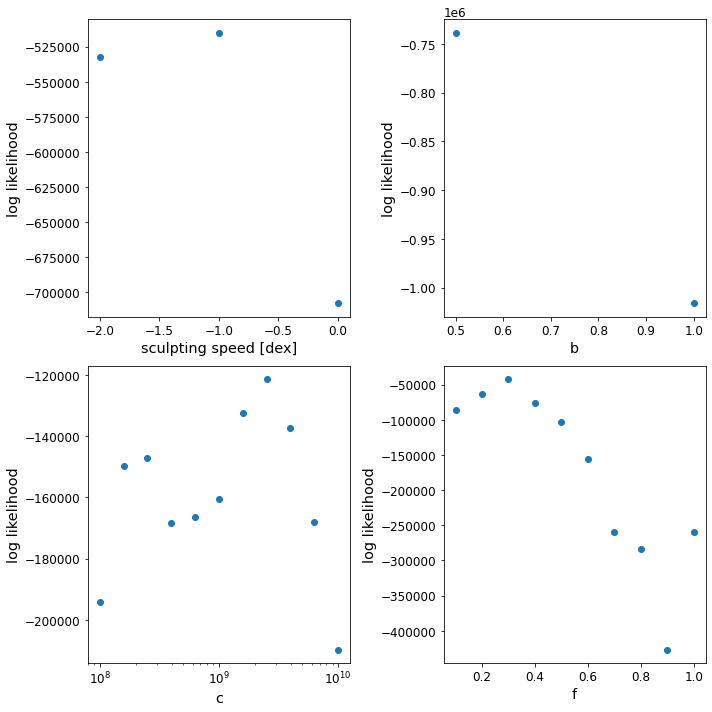

In [53]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

# marginalize in 1D
marginalized_logLs = []
for gi_m in range(3):

    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = model_logLs.loc[(model_logLs.m == cube[0])]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.sum(only.logL))

ax1.scatter(truth.ms.unique(), marginalized_logLs)
ax1.set_ylabel("log likelihood")
ax1.set_xlabel("sculpting speed [dex]")

marginalized_logLs = []
for gi_b in range(2):
    gi_b = gi_b + 1
    
    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = model_logLs.loc[(model_logLs.b == cube[1])]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.sum(only.logL))
ax2.scatter(model_logLs.b.unique(), marginalized_logLs)
ax2.set_ylabel("log likelihood")
ax2.set_xlabel("b")

marginalized_logLs = []
for gi_c in range(11):

    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = model_logLs.loc[(model_logLs.c == cube[2])]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.sum(only.logL))
ax3.scatter(truth.cs.unique(), marginalized_logLs)
ax3.set_ylabel("log likelihood")
ax3.set_xlabel("c")
ax3.set_xscale('log')

marginalized_logLs = []
for gi_f in np.linspace(0.1, 1, 10):
    
    # subset
    only = model_logLs.loc[(np.round(model_logLs.f, 1) == np.round(gi_f, 1))]
    
    # marginalize logL
    marginalized_logLs.append(np.sum(only.logL))
ax4.scatter(np.linspace(0.1, 1, 10), marginalized_logLs)
ax4.set_ylabel("log likelihood")
ax4.set_xlabel("f")

plt.tight_layout()
plt.show()

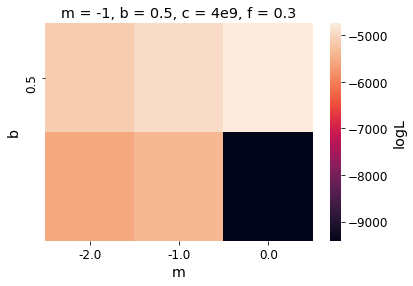

In [37]:
piv = model_logLs.groupby(['m','b','c']).mean('logL').reset_index().groupby(['m','b']).sum('logL').reset_index()

piv = piv.pivot("b","m","logL") # vs logged_normalized_likelihood
#print(np.nanmin(piv.values), np.nanmax(piv.values), np.nansum(piv.values), np.nansum(np.log(piv.values)), np.log(np.nansum(piv.values)))
#print(np.log(np.nanmin(piv.values)), np.log(np.nanmax(piv.values)))

fig, ax = plt.subplots()
sns.heatmap(piv, yticklabels=model_logLs.b.unique().round(1), cbar_kws={'label': 'logL'})
#sns.heatmap(piv, vmin=-455, vmax=-17.9)
ax.set_yticks(ax.get_yticks()[::2]) # sample every other tick, for cleanness
plt.title('m = -1, b = 0.5, c = 4e9, f = 0.3')
plt.show()

In [38]:
piv

m,-2.0,-1.0,0.0
b,,,
0.5,-5107.525974,-4927.432818,-4741.833165
1.0,-5532.992445,-5376.890655,-9413.281619


In [35]:
model_logLs.loc[model_logLs.f == 0.3].groupby(['m','b','c']).mean('logL').reset_index().groupby(['m','b']).sum('logL')

c    f         logL
m    b                                  
-2.0 0.5  2.692617e+10  3.3 -2039.354036
     1.0  2.692617e+10  3.3 -1756.797015
-1.0 0.5  2.692617e+10  3.3 -1696.260358
     1.0  2.692617e+10  3.3 -1047.170804
 0.0 0.5  2.692617e+10  3.3  -292.472633
     1.0  2.692617e+10  3.3 -1615.694456

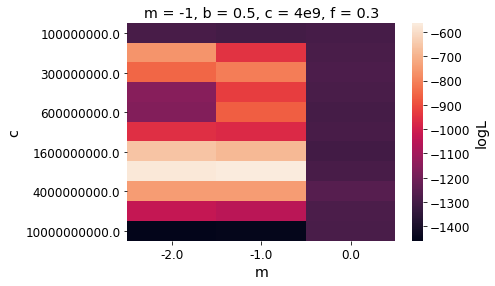

In [55]:
piv = model_logLs.groupby(['m','b','c']).mean('logL').reset_index().groupby(['m','c']).sum('logL').reset_index()

piv = piv.pivot("c","m","logL") # vs logged_normalized_likelihood
#print(np.nanmin(piv.values), np.nanmax(piv.values), np.nansum(piv.values), np.nansum(np.log(piv.values)), np.log(np.nansum(piv.values)))
#print(np.log(np.nanmin(piv.values)), np.log(np.nanmax(piv.values)))

fig, ax = plt.subplots()
sns.heatmap(piv, yticklabels=model_logLs.c.unique().round(-8), cbar_kws={'label': 'logL'})
#sns.heatmap(piv, vmin=-455, vmax=-17.9)
ax.set_yticks(ax.get_yticks()[::2]) # sample every other tick, for cleanness
plt.title('m = -1, b = 0.5, c = 4e9, f = 0.3')
plt.show()

It looks like we recover a cutoff time of 2.5 Gyrs instead of 4 Gyrs, as well as {m=0, b=0.5} instead of {m=-1, b=0.5}, although the latter is a close one, and in general the 1D posteriors show that m=0 is generally bad.

#### Model 3: m = -2, b = 1.0, c = 1e9, f = 0.3 (fast sculpting)


In [59]:
tm_fiducial = truth.loc[(truth.ms == -2) & (truth.bs == 1.) & (np.round(truth.cs, -9) == 1e9) & (np.round(truth.fs,1) == 0.3)].transit_multiplicities


In [60]:
cube = [0,0,0]
fs = np.round(np.linspace(0.1, 1.), 1)
ndim = 3
nparams = 3

ms = []
bs = []
cs = []
fs_for_df = []
all_logLs = []

for gi_m in range(3):
    
    for gi_b in range(2):
        gi_b = gi_b + 1

        for gi_c in range(11):
            cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
            
            for f in fs:
                
                ms.append(cube[0])
                bs.append(cube[1])
                cs.append(cube[2])
                fs_for_df.append(f)
                
                #tm = truth.loc[(truth.ms == cube[0]) & (truth.bs == cube[1]) & (np.round(truth.cs, 0) == cube[2]) & (np.round(truth.fs,1) == f)].transit_multiplicities
                tm_recovery = recovery.loc[(recovery.ms == cube[0]) & (recovery.bs == cube[1]) & (np.round(recovery.cs, 0) == cube[2]) & (np.round(recovery.fs,1) == f)].transit_multiplicities.to_list()
                
                # calculate logL for each realization of each model, using tm as the ground truth
                logLs = []
                for i in range(len(tm_recovery)):
                    logL = better_loglike(tm_recovery[i], np.sum(tm_fiducial))
                    logLs.append(logL)
                
                # get best logL for each model
                best_logL = np.max(logLs)
                    
                all_logLs.append(best_logL)
                
model_logLs = pd.DataFrame({'m': ms, 'b': bs, 'c': cs, 'f': fs_for_df, 'logL': all_logLs})
        

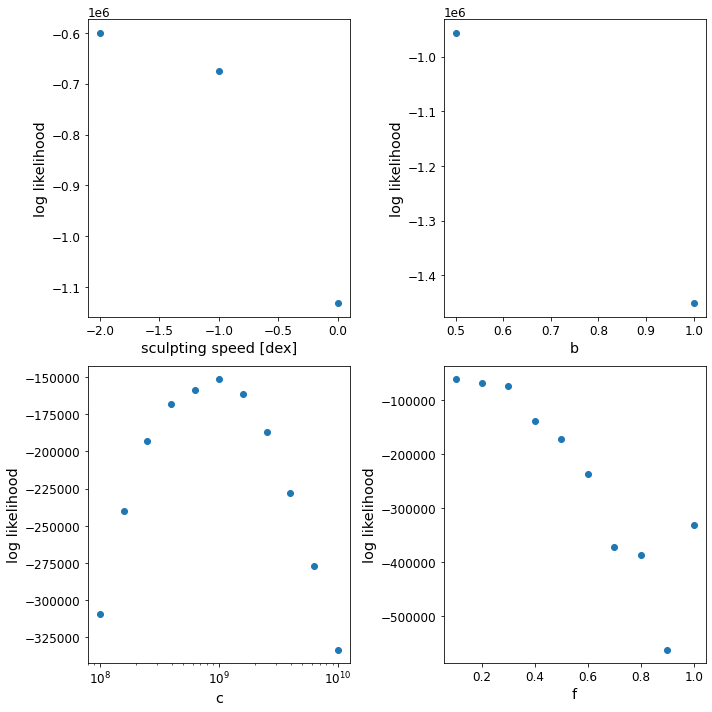

In [62]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

# marginalize in 1D
marginalized_logLs = []
for gi_m in range(3):

    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = model_logLs.loc[(model_logLs.m == cube[0])]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.sum(only.logL))

ax1.scatter(truth.ms.unique(), marginalized_logLs)
ax1.set_ylabel("log likelihood")
ax1.set_xlabel("sculpting speed [dex]")

marginalized_logLs = []
for gi_b in range(2):
    gi_b = gi_b + 1
    
    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = model_logLs.loc[(model_logLs.b == cube[1])]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.sum(only.logL))
ax2.scatter(model_logLs.b.unique(), marginalized_logLs)
ax2.set_ylabel("log likelihood")
ax2.set_xlabel("b")

marginalized_logLs = []
for gi_c in range(11):

    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = model_logLs.loc[(model_logLs.c == cube[2])]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.sum(only.logL))
ax3.scatter(truth.cs.unique(), marginalized_logLs)
ax3.set_ylabel("log likelihood")
ax3.set_xlabel("c")
ax3.set_xscale('log')

marginalized_logLs = []
for gi_f in np.linspace(0.1, 1, 10):
    
    # subset
    only = model_logLs.loc[(np.round(model_logLs.f, 1) == np.round(gi_f, 1))]
    
    # marginalize logL
    marginalized_logLs.append(np.sum(only.logL))
ax4.scatter(np.linspace(0.1, 1, 10), marginalized_logLs)
ax4.set_ylabel("log likelihood")
ax4.set_xlabel("f")

plt.tight_layout()
plt.show()

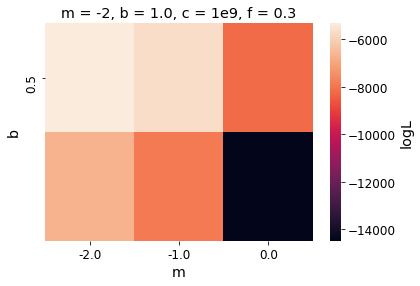

In [67]:
piv = model_logLs.groupby(['m','b','c']).mean('logL').reset_index().groupby(['m','b']).sum('logL').reset_index()

piv = piv.pivot("b","m","logL") # vs logged_normalized_likelihood
#print(np.nanmin(piv.values), np.nanmax(piv.values), np.nansum(piv.values), np.nansum(np.log(piv.values)), np.log(np.nansum(piv.values)))
#print(np.log(np.nanmin(piv.values)), np.log(np.nanmax(piv.values)))

fig, ax = plt.subplots()
sns.heatmap(piv, yticklabels=model_logLs.b.unique().round(1), cbar_kws={'label': 'logL'})
#sns.heatmap(piv, vmin=-455, vmax=-17.9)
ax.set_yticks(ax.get_yticks()[::2]) # sample every other tick, for cleanness
plt.title('m = -2, b = 1.0, c = 1e9, f = 0.3')
plt.show()

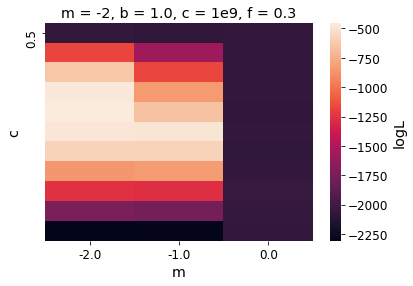

In [68]:
piv = model_logLs.groupby(['m','b','c']).mean('logL').reset_index().groupby(['m','c']).sum('logL').reset_index()

piv = piv.pivot("c","m","logL") # vs logged_normalized_likelihood
#print(np.nanmin(piv.values), np.nanmax(piv.values), np.nansum(piv.values), np.nansum(np.log(piv.values)), np.log(np.nansum(piv.values)))
#print(np.log(np.nanmin(piv.values)), np.log(np.nanmax(piv.values)))

fig, ax = plt.subplots()
sns.heatmap(piv, yticklabels=model_logLs.b.unique().round(1), cbar_kws={'label': 'logL'})
#sns.heatmap(piv, vmin=-455, vmax=-17.9)
ax.set_yticks(ax.get_yticks()[::2]) # sample every other tick, for cleanness
plt.title('m = -2, b = 1.0, c = 1e9, f = 0.3')
plt.show()

1D posteriors show that I can recover m and c, but not quite f and definitely not b. 2D posteriors corroborate this for m and b, and they suggest that there are fast sculpting models with even shorter cutoff times that are also favored. 

#### Model 4: m = 0, b = 0.5, c = 1e9, f = 0.3 (no sculpting)


In [69]:
tm_fiducial = truth.loc[(truth.ms == 0.) & (truth.bs == 0.5) & (np.round(truth.cs, -9) == 1e9) & (np.round(truth.fs,1) == 0.3)].transit_multiplicities


In [70]:
cube = [0,0,0]
fs = np.round(np.linspace(0.1, 1.), 1)
ndim = 3
nparams = 3

ms = []
bs = []
cs = []
fs_for_df = []
all_logLs = []

for gi_m in range(3):
    
    for gi_b in range(2):
        gi_b = gi_b + 1

        for gi_c in range(11):
            cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
            
            for f in fs:
                
                ms.append(cube[0])
                bs.append(cube[1])
                cs.append(cube[2])
                fs_for_df.append(f)
                
                #tm = truth.loc[(truth.ms == cube[0]) & (truth.bs == cube[1]) & (np.round(truth.cs, 0) == cube[2]) & (np.round(truth.fs,1) == f)].transit_multiplicities
                tm_recovery = recovery.loc[(recovery.ms == cube[0]) & (recovery.bs == cube[1]) & (np.round(recovery.cs, 0) == cube[2]) & (np.round(recovery.fs,1) == f)].transit_multiplicities.to_list()
                
                # calculate logL for each realization of each model, using tm as the ground truth
                logLs = []
                for i in range(len(tm_recovery)):
                    logL = better_loglike(tm_recovery[i], np.sum(tm_fiducial))
                    logLs.append(logL)
                
                # get best logL for each model
                best_logL = np.max(logLs)
                    
                all_logLs.append(best_logL)
                
model_logLs = pd.DataFrame({'m': ms, 'b': bs, 'c': cs, 'f': fs_for_df, 'logL': all_logLs})
        

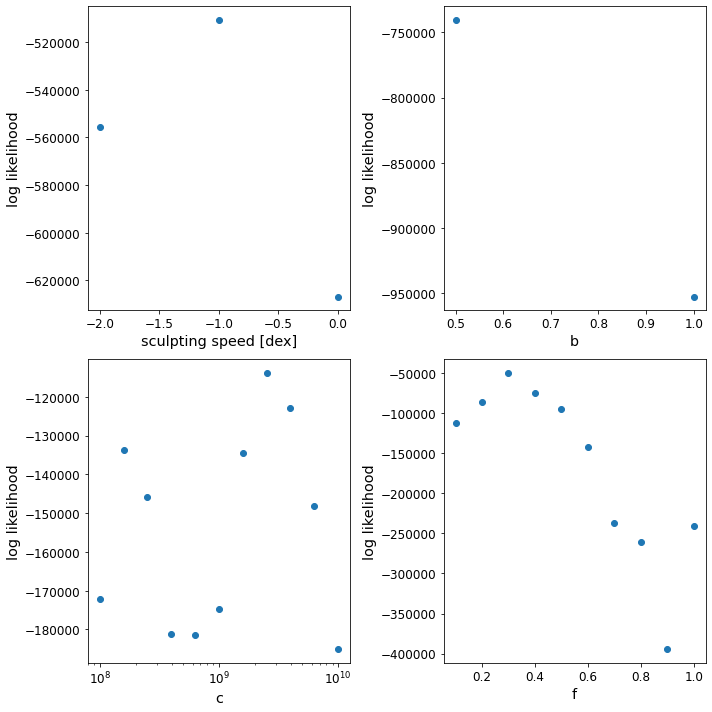

In [71]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

# marginalize in 1D
marginalized_logLs = []
for gi_m in range(3):

    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = model_logLs.loc[(model_logLs.m == cube[0])]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.sum(only.logL))

ax1.scatter(truth.ms.unique(), marginalized_logLs)
ax1.set_ylabel("log likelihood")
ax1.set_xlabel("sculpting speed [dex]")

marginalized_logLs = []
for gi_b in range(2):
    gi_b = gi_b + 1
    
    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = model_logLs.loc[(model_logLs.b == cube[1])]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.sum(only.logL))
ax2.scatter(model_logLs.b.unique(), marginalized_logLs)
ax2.set_ylabel("log likelihood")
ax2.set_xlabel("b")

marginalized_logLs = []
for gi_c in range(11):

    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = model_logLs.loc[(model_logLs.c == cube[2])]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.sum(only.logL))
ax3.scatter(truth.cs.unique(), marginalized_logLs)
ax3.set_ylabel("log likelihood")
ax3.set_xlabel("c")
ax3.set_xscale('log')

marginalized_logLs = []
for gi_f in np.linspace(0.1, 1, 10):
    
    # subset
    only = model_logLs.loc[(np.round(model_logLs.f, 1) == np.round(gi_f, 1))]
    
    # marginalize logL
    marginalized_logLs.append(np.sum(only.logL))
ax4.scatter(np.linspace(0.1, 1, 10), marginalized_logLs)
ax4.set_ylabel("log likelihood")
ax4.set_xlabel("f")

plt.tight_layout()
plt.show()

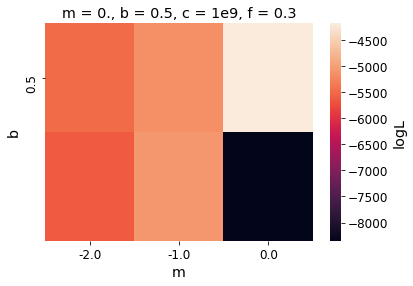

In [74]:
piv = model_logLs.groupby(['m','b','c']).mean('logL').reset_index().groupby(['m','b']).sum('logL').reset_index()

piv = piv.pivot("b","m","logL") # vs logged_normalized_likelihood
#print(np.nanmin(piv.values), np.nanmax(piv.values), np.nansum(piv.values), np.nansum(np.log(piv.values)), np.log(np.nansum(piv.values)))
#print(np.log(np.nanmin(piv.values)), np.log(np.nanmax(piv.values)))

fig, ax = plt.subplots()
sns.heatmap(piv, yticklabels=model_logLs.b.unique().round(1), cbar_kws={'label': 'logL'})
#sns.heatmap(piv, vmin=-455, vmax=-17.9)
ax.set_yticks(ax.get_yticks()[::2]) # sample every other tick, for cleanness
plt.title('m = 0., b = 0.5, c = 1e9, f = 0.3')
plt.show()

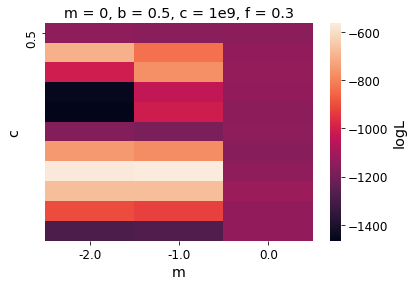

In [75]:
piv = model_logLs.groupby(['m','b','c']).mean('logL').reset_index().groupby(['m','c']).sum('logL').reset_index()

piv = piv.pivot("c","m","logL") # vs logged_normalized_likelihood
#print(np.nanmin(piv.values), np.nanmax(piv.values), np.nansum(piv.values), np.nansum(np.log(piv.values)), np.log(np.nansum(piv.values)))
#print(np.log(np.nanmin(piv.values)), np.log(np.nanmax(piv.values)))

fig, ax = plt.subplots()
sns.heatmap(piv, yticklabels=model_logLs.b.unique().round(1), cbar_kws={'label': 'logL'})
#sns.heatmap(piv, vmin=-455, vmax=-17.9)
ax.set_yticks(ax.get_yticks()[::2]) # sample every other tick, for cleanness
plt.title('m = 0, b = 0.5, c = 1e9, f = 0.3')
plt.show()

We totally miss the mark on recovering the lack of sculpting in the fake ground truth. We do recover b and f, and of course c is a latent variable in the case of no sculpting. 

#### Model 5: ???
